# Digital Lung Biopsy

In [1]:
import pandas as pd
import os
from ast import literal_eval
from scipy.stats import entropy, skew, kurtosis, mode, iqr, sem, gstd, wasserstein_distance, ks_2samp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns

/Users/jacobmurray/.pyenv/versions/3.9.0/envs/base/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
### SET UP

def walk_dir_to_file_list(directory, condition_function=lambda x: True):
    file_list = []
    for root, dirs, files in os.walk(directory):    
        for file in files:
            if condition_function(file):
                file_list.append(os.path.join(root, file))
    return file_list


def df_from_xlsx(xlsx, sheet_name=None, header=0):
    xl = pd.ExcelFile(xlsx)
    center = os.path.basename(xlsx).split('-')[0]
    sheet_name = sheet_name if sheet_name else xl.sheet_names[0]
    df = xl.parse(sheet_name, header=header)
    df['center'] = center
    return df

def prep_df(df, bins=20, lb_cutoff=0, ub_cutoff=0.1, normalize=False):
    df = df[df.apply(lambda x: x['histogram'].endswith(']'), axis=1)]
    df = df[df.apply(lambda x: x['histogram'] != '[]', axis=1)]
    df = df[df.apply(lambda x: pd.isna(x['Lesion_class']) == False, axis=1)]
    df['histogram'] = df['histogram'].apply(lambda x: literal_eval(x))

    # remove outliers 
    all_data = np.asarray([i for l in df['histogram'].values for i in l])
    lb_hu = np.percentile(all_data, lb_cutoff)
    ub_hu = np.percentile(all_data, 100-ub_cutoff) 
    df['histogram'] = df['histogram'].apply(lambda x: [i for i in x if i>lb_hu and i<ub_hu])
    df = df[df.apply(lambda x: x['histogram'] != [], axis=1)]
    
    # add reference and air
    df_air = df[df['Lesion_class'] == 'Digitale Stanze Luft (prästernale Höhe)']
    df_air = df_air[['PatientID', 'StudyID', 'histogram']]
    df_air = df_air.rename(columns={'histogram': 'air_histogram'})

    df_lung = df[df['Lesion_class'] == 'Referenzmessung Lunge']
    df_lung = df_lung[['PatientID', 'StudyID', 'histogram']]
    df_lung = df_lung.rename(columns={'histogram': 'lung_histogram'})

    df = df.merge(df_air, how='left', on=['PatientID', 'StudyID'])
    df = df.merge(df_lung, how='left', on=['PatientID', 'StudyID'])

    df_drop = df[(pd.isna(df['air_histogram'])) | (pd.isna(df['lung_histogram']))]
    if len(df_drop) > 0:
        print(f'... dropping {len(df_drop)} records, because no air or lung histogram is present')
    df = df[~((pd.isna(df['air_histogram'])) | (pd.isna(df['lung_histogram'])))]

    # take out air and normal lung 
    df = df[~df['Lesion_class'].isin(['Digitale Stanze Luft (prästernale Höhe)', 'Referenzmessung Lunge'])]    
    
    # discuss normalization procedure 
    if normalize:
        df['air_histogram_mean'] = df.apply(lambda x: np.mean(x['air_histogram']), axis=1)
        df['histogram'] = df.apply(lambda x: list(np.asarray(x['histogram']) - x['air_histogram_mean']), axis=1)
        df['lung_histogram'] = df.apply(lambda x: list(np.asarray(x['lung_histogram']) - x['air_histogram_mean']), axis=1)    
        df['air_histogram'] = df.apply(lambda x: list(np.asarray(x['air_histogram']) - x['air_histogram_mean']), axis=1)
    df.normalized = normalize
    
    # get histogram edges
    all_data = np.asarray([i for l in df['histogram'].values for i in l])
    counts, edges = np.histogram(all_data, bins=bins)    

    return df, edges


def calc_features(df, features):
    for k, v in features.items():
        df[k] = df.apply(lambda x: v[0](*[x[p] for p in v[1]]), axis=1)
    return df
    

def load_dir(path, features, bins=20, lb_cutoff=0, ub_cutoff=0.1, normalize=False, centers=None):
    print('Load for directory: {}'.format(path))
    xlsxs = walk_dir_to_file_list(path, lambda x: x.endswith('.xlsx'))
    centers = [os.path.basename(x).split('-')[0] for x in xlsxs] if not centers else centers
    dfs = []
    for x in xlsxs:
        if os.path.basename(x).split('-')[0] in centers:
            print('-'*80)
            print('Loading file: {}'.format(x))
            df = df_from_xlsx(x)
            print('(1) Preparing dataframe.')
            df, edges = prep_df(df, bins=bins, lb_cutoff=lb_cutoff, ub_cutoff=ub_cutoff, normalize=normalize)
            print('(2) Calculating features.')
            features = set_entropy_bins(features, edges)
            df = calc_features(df, features)
            dfs.append(df)
            print('-'*80)
    df = pd.concat(dfs)
    print('Complete.')
    return df, features.keys()
        

def set_entropy_bins(features, edges):
    features['entropy'] = (lambda x: entropy(np.histogram(x, bins=edges)[0]), ['histogram'])
    return features
    
    
    
##### FEATURES
# defined as {feature_name: (feature_function, [feature_function_argument_df_cols])}


fxs = {
    'mean': (np.mean, ['histogram']),
    'stdev': (np.std, ['histogram']),
    'mode': (lambda x: mode(x)[0][0], ['histogram']), 
    'median': (np.median, ['histogram']), 
    'min': (np.min, ['histogram']),
    'max': (np.max, ['histogram']),
    'skew': (skew, ['histogram']),
    'kurtosis': (kurtosis, ['histogram']),
    'entropy': (lambda x: entropy(np.histogram(x, bins=edges)[0]), ['histogram']), 
    'iqr': (iqr, ['histogram']),
    'ks': (lambda x, y: ks_2samp(x, y)[0], ['histogram', 'lung_histogram']),
    'wasserstein': (wasserstein_distance, ['histogram', 'lung_histogram'])
}




In [92]:
# df, feature_keys = load_dir('./data', fxs)
dfn, _ = load_dir('./data', {}, normalize=True)

Load for directory: ./data
--------------------------------------------------------------------------------
Loading file: ./data/UEAU-lesion_histogram_list.xlsx
(1) Preparing dataframe.
(2) Calculating features.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Loading file: ./data/UKL-lesion_histogram_list.xlsx
(1) Preparing dataframe.
... dropping 1 records, because no air or lung histogram is present
(2) Calculating features.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Loading file: ./data/UME-lesion_histogram_list.xlsx
(1) Preparing dataframe.
(2) Calculating features.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Loading file: ./data/FAU-les

# 2. Dimensionality Reduction 

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [12]:
def pca(df, features, by=None, n_components=2):
    if by:
        dfs = [df[df[by] == i] for i in df[by].unique()]
    else:
        dfs = [df]
    for d in dfs:
        X = d[features]
        pca = PCA(n_components=n_components)
        X_r = pca.fit(X).transform(X)
        print('[PCA] Explained variance ratio: %s'
            % str(pca.explained_variance_ratio_))
        for i in range(n_components):
            d['pca_dim_' + str(i + 1)] = X_r[:, i]
    return pd.concat(dfs) 

def tsne(df, features, by=None, n_components=2, verbose=1, perplexity=40, n_iter=300):
    if by:
        dfs = [df[df[by] == i] for i in df[by].unique()]
    else:
        dfs = [df]
    for d in dfs:
        X = d[features]
        tsne = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter)
        X_r = tsne.fit_transform(X)
        for i in range(n_components):
            d['tsne_dim_' + str(i + 1)] = X_r[:, i]
    return pd.concat(dfs)


In [20]:
%%capture
df = pca(df, feature_keys)
df = tsne(df, feature_keys)

# 3. Analysis 
## 3.1 RACOON Presentation Nov 2021
### 3.1.1 tSNE nach biopsy subset und center

In [21]:
biopsy_subset = ['Pleuraerguss', 'Konsolidierung', 'Milchglassareal', 'Retikulation', 'Emphysem', 'Pneumothorax', 'Raumforderung > 30 mm']
dfa = df[df['Lesion_class'].isin(biopsy_subset)].copy()
dfa['center'] = dfa['center'].astype('category')
dfa['center_number'] = dfa['center'].cat.codes


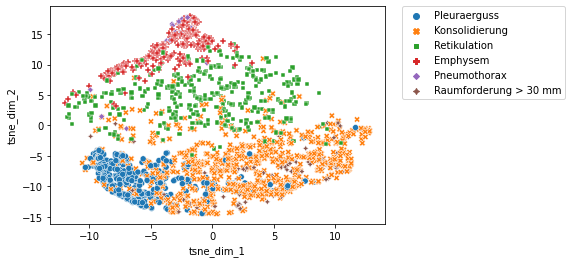

In [25]:
sns.scatterplot(data=dfa, x='tsne_dim_1', y='tsne_dim_2', hue="Lesion_class", style="Lesion_class")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# p = sns.relplot(
#     data=dfa, x="pca_dim_1", y="pca_dim_2",
#     col="center_number", hue="Lesion_class", style="Lesion_class",
#     kind="scatter", col_wrap=3
# )

# legend = p._legend
# legend.set_bbox_to_anchor([0.8, 0.2])
# legend.set_title('Lesion class')
# legend._loc = (0.8, 0)


### 3.1.2 Histogramme der Raumforderungsstanzen

Result: No good seperability of different lesions.

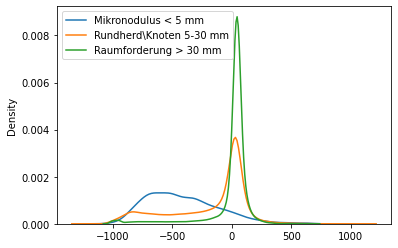

In [71]:
rf_stanzen = ['Mikronodulus < 5 mm', 'Rundherd\\Knoten 5-30 mm', 'Raumforderung > 30 mm']

# Strange finding:
# lens = [len(i) for i in df[df['Lesion_class'] == 'Mikronodulus < 5 mm']['histogram']]
# print('Average number of intensity values for micronodulus < 5 mm', np.mean(lens))

fig, ax = plt.subplots()
for i in rf_stanzen: 
    sns.kdeplot([i for j in df[df['Lesion_class'] == i]['histogram'] for i in j], ax=ax, label=i)
plt.legend();


### 3.1.3 Variance by Center

In [108]:
dfa.normalized = False
dfn.normalized = True
dfs = [dfa, dfn]
centers = dfs[0]['center'].unique()
lesions = dfa['Lesion_class'].unique()

l = []
for d in dfs:
    for c in centers:
        for lc in lesions:
            own_mean = np.mean([i for j in d[(d['Lesion_class'] == lc) & (d['center'] == c)]['histogram'] for i in j])
            oth_mean = np.mean([i for j in d[(d['Lesion_class'] == lc) & (d['center'] != c)]['histogram'] for i in j])
            dff_mean = oth_mean - own_mean 
            l.append({
                'center': c, 
                'lesion_class': lc,
                'own_mean': own_mean,
                'oth_mean': oth_mean,
                'dff_mean': dff_mean,
                'normalized': d.normalized
            })
        
dfv = pd.DataFrame(l)


AttributeError: 'str' object has no attribute 'set_visible'

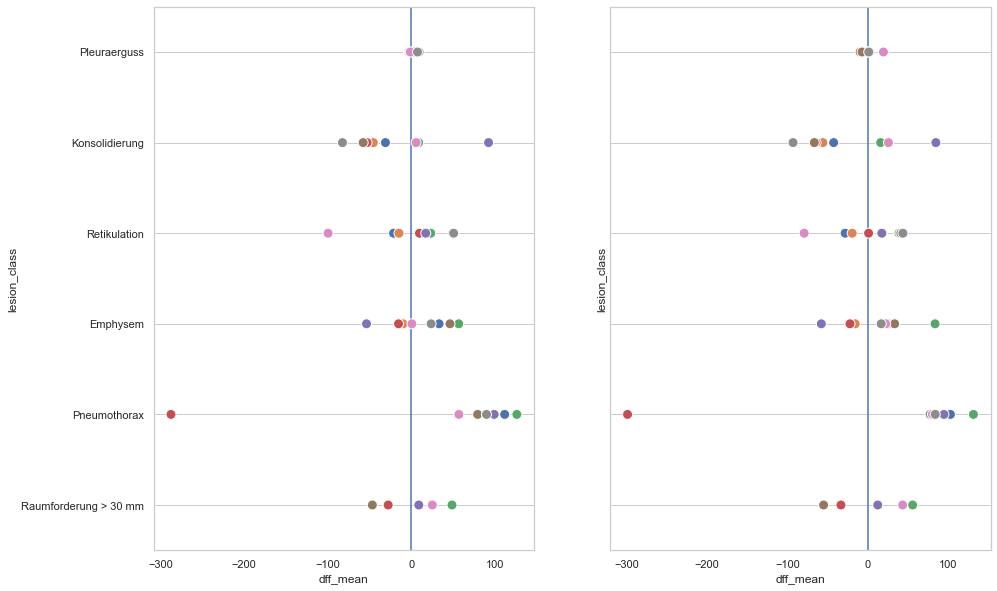

In [113]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey=True)
for i, v in enumerate([False, True]):
    sns.stripplot(data=dfv[dfv['normalized'] == v], x='dff_mean',y='lesion_class', size=10, orient="h", jitter=False, linewidth=1, edgecolor="w", ax=ax[i], hue='center')
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(False)
    ax[i].get_legend().remove()
    ax[i].axvline(x=0)

    if i == 1:
        ax[i].label.set_visible(False)


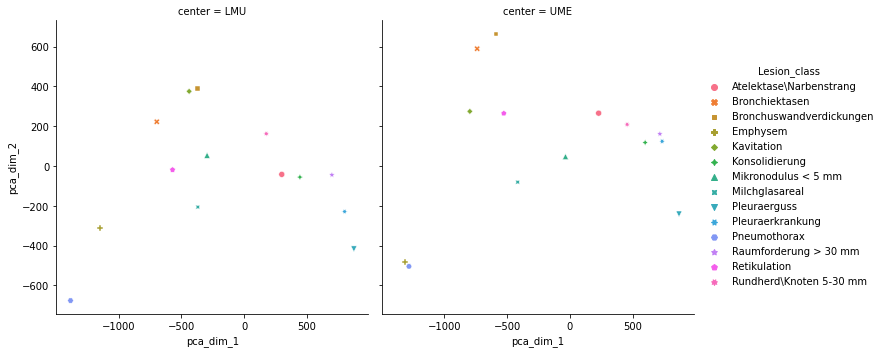

In [107]:
sns.relplot(
    data=dfg, x="pca_dim_1", y="pca_dim_2",
    col="center", hue="Lesion_class", style="Lesion_class",
    kind="scatter"
)

# 3. Classification
## 3.1. RandomForest

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_keys].values, df['Lesion_class'].values, test_size=0.2, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5135869565217391

In [112]:
for i, k in zip(feature_keys, clf.feature_importances_):
    print(i,k)

mean 0.1691407920137724
stdev 0.10002522322363112
mode 0.08661671361803615
median 0.15852454675847427
min 0.08852004185010784
max 0.07131122742844695
skew 0.0655470092069053
kurtosis 0.0
entropy 0.02792266898261388
iqr 0.047377656535877534
ks 0.0049307197815604345
wasserstein 0.18008340060057407


<AxesSubplot:>

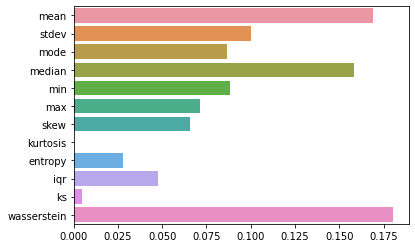

In [122]:
sns.barplot(y=list(feature_keys), x=clf.feature_importances_, orient= 'h')